# 含噪声量子线路

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/mindspore_noise.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/mindspore_noise.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/noise.ipynb)

## 概述

在真实量子设备中，由于现阶段技术的不成熟，量子系统会由于量子操作、环境影响等各种因素而产生噪声。现阶段噪声对量子设备的影响不可忽略，因此在量子线路中加入对噪声的模拟，可以帮助我们寻找对噪声具有鲁棒性的量子算法，或设计减少噪声影响的纠错方案。

噪声分为两种类型：相干噪声和非相干噪声。相干噪声一般来源于门操作中参数的噪声化，因此是幺正演化并且易于模拟；非相干噪声则来源于系统与环境的相互作用，因此通常是非幺正演化，会使量子系统从纯态变为混态，这个过程也被称为量子信道（Quantum channel）。混态的量子系统通常用密度矩阵的形式表示，但也可以通过“采样-统计”的蒙特卡洛法得到统计模拟结果。在MindSpore Quantum中，我们用蒙特卡洛法来模拟量子信道，其中噪声门会以一定概率影响量子比特，通过对线路的多次采样，可以得到含噪声量子线路的模拟运行结果。

量子信道的数学表示如下：

$$
\varepsilon(\rho) =\sum_{k=0}^{m-1} E_{k} \rho E_{k}^{\dagger}
$$

其中$\{E_k\}$是Kraus算符，需要满足完备性条件$\sum_k E_k^\dagger E_k= I$；$\rho$是量子态的密度矩阵，$\varepsilon(\rho)$是演化后的量子态。

## 泡利信道（Pauli Channel）

有一类噪声对量子线路的影响体现为，当进行了某种量子操作后，线路有概率额外受到一个泡利门的影响，被称为泡利信道。例如，经过某个操作后比特以一定概率被额外作用一个`X`门，即该比特以一定概率发生了翻转，这就是比特翻转信道(Bit Flip Channel)，数学表示为：

$$
\varepsilon_{BF}( \rho ) =(1-p)I \rho I +pX \rho X
$$

其中$I$是单位矩阵，$X$是泡利`X`门。该信道对应的Kraus算符为：

$$
E_0=\sqrt{1-p}\begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}, E_{1} =\sqrt{p}\begin{bmatrix}
0 & 1\\
1 & 0
\end{bmatrix}
$$

其中$p$可以视为发生比特翻转的概率。由这个例子可以看到，一个纯态量子态经过比特翻转信道后会变为混态，该混态由原本的态和比特翻转后的态构成。

同理，若比特以一定概率额外作用一个`Z`门称为相位翻转信道，`Y`门是比特相位翻转信道。若是`X`、`Y`、`Z`三个门平分概率，则称为去极化信道，该信道常常被用来描述真实量子硬件中门操作产生的噪声。此外，也可以使用通用的泡利信道自定义三个泡利门的概率。

下面是这些信道的数学表示。

泡利信道（Pauli Channel）：

$$
\varepsilon _{Pauli}( \rho ) =(1-p_x-p_y-p_z)\rho + p_x X \rho X+ p_y Y \rho Y+p_z Z \rho Z
$$

相位翻转信道（Phase Flip Channel）：

$$
\varepsilon _{PF}( \rho ) =(1-p)\rho +pZ \rho Z
$$

比特相位翻转信道（Bit-Phase Flip Channel）：

$$
\varepsilon _{BPF}( \rho ) =(1-p)\rho +pY \rho Y
$$

去极化信道（Depolarizing Channel）：

$$
\varepsilon _{DF}( \rho ) =(1-p)\rho + \frac{p}{3}(X \rho X+ Y \rho Y+Z \rho Z)
$$

下面我们以去极化信道为例，看看如何将噪声信道加入线路中。

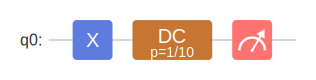

In [9]:
from mindquantum.core.gates import DepolarizingChannel, X
from mindquantum.core.circuit import Circuit

circ = Circuit()
circ += X.on(0)
circ += DepolarizingChannel(0.1).on(0)
circ.measure(0)
circ.svg()

此时我们成功搭建了一个单比特的量子线路，该比特在作用`X`门后，会受到去极化噪声的影响，具体表现为有10%概率额外作用一个泡利门，其中`X`、`Y`、`Z`门平分概率。

现在我们对该线路进行1000次模拟并输出采样结果：

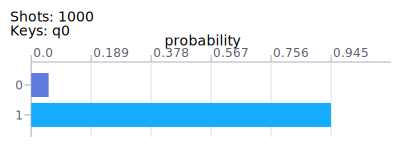

In [10]:
from mindquantum.simulator import Simulator

sim = Simulator('mqvector', 1)
result = sim.sampling(circ, shots=1000)
result.svg()

倘若没有噪声影响，量子态应该处于$|1\rangle$态，测量结果全为1，但在以上结果中，约有7%的模拟结果测得为0，这就是去极化信道产生的影响。采样结果与预期中3.3%概率额外作用`X`门、`Y`门和`Z`门的预测结果相符。

至此我们就完成了一次对含去极化噪声量子线路的模拟。



## 阻尼信道（Damping Channel）

振幅阻尼信道（Amplitude Damping Channel）和相位阻尼信道（Phase Damping Channel）也是比较常见的信道，其中振幅阻尼信道描述了量子系统能量的耗散，相位阻尼信道则描述了系统量子信息的损失。具体来说，振幅阻尼信道会使量子比特从激发态回到基态，相位阻尼信道则会使量子比特从叠加态退回到坍缩态。

振幅阻尼信道的表达形式为：

$$
\varepsilon_{AD}( \rho ) =E_{0} \rho E_{0}^{\dagger } +E_{1} \rho E_{1}^{\dagger }
$$

其中$E_{0}, E_{1}$是Kraus算符，

$$
E_{0} =\begin{bmatrix}
1 & 0\\
0 & \sqrt{1-\gamma }
\end{bmatrix}, E_{1} =\begin{bmatrix}
0 & \sqrt{\gamma }\\
0 & 0
\end{bmatrix}
$$

$\gamma$为耗散系数。

相位阻尼信道的表达形式为：

$$
\varepsilon_{PD}( \rho ) =E_{0} \rho E_{0}^{\dagger } +E_{1} \rho E_{1}^{\dagger }
$$

其中

$$
E_{0} =\begin{bmatrix}
1 & 0\\
0 & \sqrt{1-\gamma }
\end{bmatrix}, E_{1} =\begin{bmatrix}
0 & 0\\
0 & \sqrt{\gamma }
\end{bmatrix}
$$

$\gamma$为损失系数。

由以上两式可以发现，阻尼信道的Kraus算符不具有幺正性，因此阻尼信道不能表示为以一定概率作用量子门的形式。
接下来我们来看看两个阻尼信道的效果，首先是振幅阻尼信道。

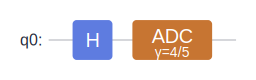

In [11]:
from mindquantum.core.gates import AmplitudeDampingChannel, H

circ2 = Circuit()
circ2 += H.on(0)
circ2 += AmplitudeDampingChannel(0.8).on(0)
circ2.svg()

In [12]:
# 将线路演化5次并打印量子态
for i in range(5):
    sim.reset()                 # 初始化模拟器
    sim.apply_circuit(circ2)    # 演化线路
    print(sim.get_qs(ket=True)) # 获取量子态
    print()

1¦0⟩

0.912870929175277¦0⟩
0.408248290463863¦1⟩

0.912870929175277¦0⟩
0.408248290463863¦1⟩

1¦0⟩

1¦0⟩



从以上采样结果可以看出，振幅阻尼信道作用在叠加态 $|\psi\rangle=|0\rangle+|1\rangle$态后会使其变为混态，混态的其中一部分是$|0\rangle$态，另一部分仍是叠加态，但$|1\rangle$态的振幅发生了衰减。该混态的比例由初始量子态和耗散系数$\gamma$共同决定，初始量子态中的$|1\rangle$态振幅越大，混态中$|0\rangle$态的比例就越大。

具体来说，对于初始量子态 $|\psi\rangle=a|0\rangle+b|1\rangle$，振幅阻尼信道作用后变成$|0\rangle$态的概率为 $p=\gamma b^2$，或以$(1-p)$的概率变为叠加态 $|\psi'\rangle=\frac{1}{\sqrt{1-\gamma b^{2}}}(a|0\rangle+b\sqrt{1-\gamma}|1\rangle)$。

由此可见，量子比特经过振幅阻尼信道后能量发生耗散，叠加态中激发态$|1\rangle$态的部分减少，或者直接变为基态$|0\rangle$态。

接下来是相位阻尼信道。

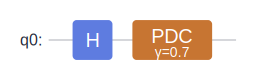

In [13]:
from mindquantum.core.gates import PhaseDampingChannel

circ3 = Circuit()
circ3 += H.on(0)
circ3 += PhaseDampingChannel(0.7).on(0)
circ3.svg()

In [14]:
# 将线路演化5次并打印量子态
for i in range(5):
    sim.reset()                 # 初始化模拟器
    sim.apply_circuit(circ3)    # 演化线路
    print(sim.get_qs(ket=True)) # 获取量子态
    print()

1¦1⟩

0.8770580193070293¦0⟩
0.4803844614152615¦1⟩

1¦1⟩

1¦1⟩

0.8770580193070293¦0⟩
0.4803844614152615¦1⟩



与振幅阻尼信道类似，相位阻尼信道作用在叠加态 $|\psi\rangle=|0\rangle+|1\rangle$态后同样会使其变为混态，混态的其中一部分是$|1\rangle$态，另一部分仍是叠加态，但$|1\rangle$态的振幅发生了衰减。该混态的比例由初始量子态和耗散系数$\gamma$共同决定，初始量子态中的$|1\rangle$态振幅越大，混态中$|1\rangle$态的比例就越大。

具体来说，对于初始量子态 $|\psi\rangle=a|0\rangle+b|1\rangle$，相位阻尼信道作用后变成$|1\rangle$态的概率为 $p=\gamma b^2$，或以$(1-p)$的概率变为叠加态 $|\psi'\rangle=\frac{1}{\sqrt{1-\gamma b^{2}}}(a|0\rangle+b\sqrt{1-\gamma}|1\rangle)$。

由此可见，量子比特经过相位阻尼信道后并没有损失能量，但量子信息（这里体现为量子态叠加）发生了损失。

## 实例演示——含噪声QAOA

量子近似优化算法（Quantum Approximate Optimization Algorithm）是利用量子计算机来近似解决组合优化问题的量子算法，详尽的介绍可以参考教案[quantum_approximate_optimization_algorithm.ipynb](https://mindspore.cn/mindquantum/docs/zh-CN/master/quantum_approximate_optimization_algorithm.html)，在此我们以该算法为案例，看看引入噪声会对量子算法产生怎样的影响。在这里我们与QAOA教案保持一致，解决同一个图的Max-Cut问题。

由于目前模拟器采用蒙特卡洛法模拟噪声，每次演化线路的结果具有随机性，与真实量子计算机类似，但也因此需要多次采样并分析统计结果，即每次计算哈密顿量期望值之前都需要先重新演化线路。与此同时，我们也无法直接得到含噪声量子线路的梯度，因此需要采用非梯度的优化方法。Nelder-Mead法可以得到多元标量函数的最小值，这里我们采用它来优化含参线路，得到目标哈密顿量期望值的最小值。

max cut: 4.716655809015849


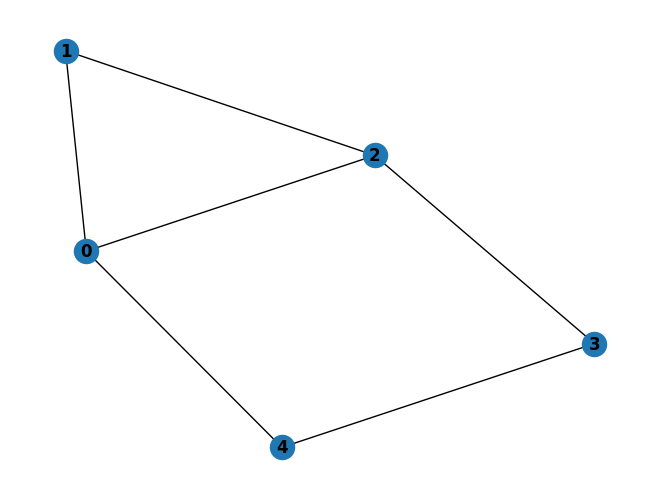

In [15]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, RX, Rzz, AmplitudeDampingChannel
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.simulator import Simulator
from scipy.optimize import minimize
import networkx as nx
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

# 生成待求解的图
g = nx.Graph()
nx.add_path(g, [0, 1])
nx.add_path(g, [1, 2])
nx.add_path(g, [2, 3])
nx.add_path(g, [3, 4])
nx.add_path(g, [0, 4])
nx.add_path(g, [0, 2])
nx.draw(g, with_labels=True, font_weight='bold')

gamma = 0.005                                        # 设定振幅阻尼信道的耗散系数
circ = Circuit(UN(H, g.nodes))                       # 生成均匀叠加态
circ += UN(AmplitudeDampingChannel(gamma), g.nodes)  # 假设每个H门作用后都会出现噪声

# 生成ansatz线路，详细的原理请参考QAOA教案
for i in range(4):
    for j in g.edges:
        circ += Rzz(f'g{i}').on(j)                    # 对图中的每条边作用ZZ门
    circ.barrier(False)
    for j in g.nodes:
        circ += RX(f'b{i}').on(j)                    # 对每个节点作用RX门
        circ += AmplitudeDampingChannel(gamma).on(j) # 假设每个RX门作用后都会出现噪声
    circ.barrier(False)

# 生成哈密顿量
ham = QubitOperator()
for i in g.edges:
    ham += QubitOperator(f'Z{i[0]} Z{i[1]}')
ham = Hamiltonian(ham)

sim = Simulator('mqvector', circ.n_qubits)           # 初始化模拟器

# 定义待优化的函数，由于噪声存在，每次需要重新演化线路
def func(x):
    sim.reset()                                      # 重置模拟器
    sim.apply_circuit(circ, x)                       # 演化线路，参数x是优化器生成的线路参数数值
    f = sim.get_expectation(ham).real                # 计算并返回哈密顿量的期望值
    return f

# 设置线路参数的初始数值
n_paras = len(circ.params_name)
init_amp = [0.0 for i in range(n_paras)]

res = minimize(func, init_amp, method='nelder-mead') # 使用优化器优化参数，得到哈密顿量期望值的最小值，优化方法是nelder-mead
cut = (len(g.edges) - res.fun) / 2                   # 计算max-cut数
print('max cut:', cut)                               # 打印结果

从结果可以看出，受到噪声影响，QAOA算法的结果变差，但当耗散系数不高时还是能收敛得到一个接近的结果。

In [16]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.0
scipy,1.10.1
numpy,1.23.5
System,Info
Python,3.8.17
OS,Windows AMD64
Memory,8.39 GB
CPU Max Thread,8
Date,Mon Sep 18 11:13:57 2023
